
# Atividade: Ciclo Solar e Rotação do Sol

**Objetivo da aula:**  
- Carregar dados reais de manchas solares.  
- Fazer o **diagrama da borboleta** (latitude das manchas vs. tempo).  
- Visualizar a **área total de manchas** como função do tempo.
- Calcular o **periodograma** dessa série temporal para explorar periodicidades.

> **Dica:** Rode uma célula de cada vez (Shift+Enter).

In [40]:

# Imports essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [41]:
#Baixe o arquivo CSV para sua pasta no Drive e declare o caminho do arquivo:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
caminho_dados = Path('/content/drive/MyDrive/lab/manchas_1874_2016.csv')
# caminho_dados = Path('../dados/manchas_1874_2016.csv')

# Se for necessário, ajuste o caminho acima
print("Arquivo existe?", "Sim" if caminho_dados.exists() else "Não")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivo existe? Sim



## 1) Carregar e entender os dados

Vamos:
1. Ler o CSV.  
2. Padronizar nomes de colunas.  
3. Identificar as colunas principais: **tempo**, **latitude** e **área**.  
4. Fazer uma limpeza mínima.


In [42]:

# Leitura do CSV
df_orig = pd.read_csv(caminho_dados)

print('Colunas disponíveis:', list(df_orig.columns))
df_orig.head(20)


Colunas disponíveis: ['ano', 'mes', 'dia', 'frac_dia', 'grupo', 'area', 'latitude', 'ano_decimal']


,ano,mes,dia,frac_dia,grupo,area,latitude,ano_decimal
0,1874,5,1,0.000,NaN,0,0.0,1874.333333
1,1874,5,2,0.000,NaN,0,0.0,1874.336073
2,1874,5,3,0.000,NaN,0,0.0,1874.338813
3,1874,5,4,0.000,NaN,0,0.0,1874.341553
4,1874,5,5,0.000,NaN,0,0.0,1874.344292
5,1874,5,6,0.000,NaN,0,0.0,1874.347032
6,1874,5,7,0.000,NaN,0,0.0,1874.349772
7,1874,5,8,0.000,NaN,0,0.0,1874.352511
8,1874,5,9,0.497,86.0,378,7.4,1874.355253
9,1874,5,9,0.497,87.0,852,-7.0,1874.355253


### Estatísticas básicas (`describe()`)

Mostra contagens, média, desvio padrão, mínimos/máximos e quartis das colunas numéricas.Útil para conferir **ordens de grandeza** e se há valores estranhos.


In [43]:
#Estatísticas básicas
df_orig.describe()

,ano,mes,dia,frac_dia,grupo,area,latitude,ano_decimal
count,246266.000000,246266.000000,246266.000000,246266.000000,246135.000000,246266.000000,246266.000000,246266.000000
mean,1953.770139,6.521347,15.686887,0.426261,13604.708217,159.907433,0.154933,1954.270463
std,36.604473,3.430899,8.814245,0.108397,19291.218144,263.874689,16.846765,36.604194
min,1874.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-59.500000,1874.333333
25%,1927.000000,4.000000,8.000000,0.349000,5491.000000,20.000000,-14.500000,1927.132650
50%,1958.000000,7.000000,16.000000,0.456000,10025.000000,68.000000,1.500000,1958.041097
75%,1983.000000,9.000000,23.000000,0.500000,16135.000000,190.000000,14.500000,1983.315755
max,2016.000000,12.000000,31.000000,0.990000,164903.000000,6132.000000,59.700000,2016.752734


### Tipos das colunas (`dtypes`)

Exibe o tipo de cada coluna (número, texto, data). Isso ajuda a decidir como tratar cada uma.

In [44]:
df_orig.dtypes

,0
ano,int64
mes,int64
dia,int64
frac_dia,float64
grupo,float64
area,int64
latitude,float64
ano_decimal,float64


In [45]:
# Utilizaremos o tempo em ano decimal, calculado como na fórmula abaixo:
def to_decimal_year(ano, mes, dia, frac_dia):
    return ano + (mes - 1)/12 + (dia - 1)/365 + frac_dia/365

# Limpeza mínima tirando linhas de dados não existentes.
df = df_orig.dropna(subset=['ano_decimal'])
if 'latitude' in df.columns:
    df = df.dropna(subset=['latitude'])
if 'area' in df.columns:
    df = df.dropna(subset=['area'])

# Filtros físicos simples
# Modifique caso queira restringir mais os dados a serem analisados:
if 'latitude' in df.columns:
    df = df[df['latitude'].between(-90, 90)]
if 'area' in df.columns:
    df = df[df['area'] > 0]

df = df.sort_values('ano_decimal').reset_index(drop=True)

df[['ano_decimal', 'latitude', 'area']].head()


,ano_decimal,latitude,area
0,1874.355253,7.4,378
1,1874.355253,-7.0,852
2,1874.355253,20.5,68
3,1874.357991,7.3,287
4,1874.357991,-5.2,167



## 2) Diagrama da Borboleta

O **diagrama da borboleta** mostra a latitude das manchas solares ao longo do tempo.  
Nesta versão simples, vamos fazer um *scatter* de `ano_decimal` vs `latitude`.

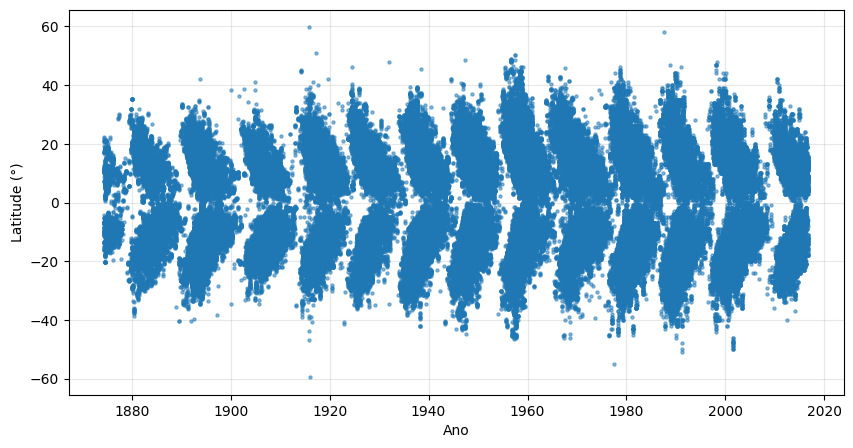

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(df['ano_decimal'], df['latitude'], s=5, alpha=0.5, zorder=10)
plt.xlabel('Ano')
plt.ylabel('Latitude (°)')
plt.grid(True, alpha=0.3, zorder=0)
plt.show()



### Colorir a borboleta

**Exemplo**: abaixo, dividimos em pequenas e grandes áreas.

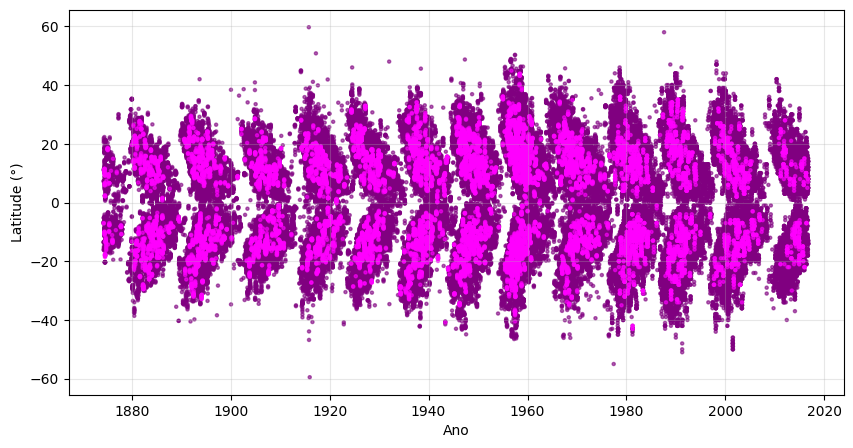

In [48]:
#ordena a tabela por área das manchas, passo importante para a visualização.
df = df.sort_values(by='area', ascending=True)

area = df['area']

conditions = [
    (area <= 500),
    (area > 500)
]

choices = ['purple','magenta']

cores = np.select(conditions, choices, default='purple').tolist()

plt.figure(figsize=(10,5))
plt.scatter(df['ano_decimal'], df['latitude'], s=5, alpha=0.6, c=cores)
plt.xlabel('Ano'); plt.ylabel('Latitude (°)')
plt.grid(True, alpha=0.3)
plt.show()

### **Desafio** #1 — Colorir o diagrama da borboleta por área das manchas
refazer o diagrama da borboleta acima com 3 grupos (pequena / média / grande).


## 3) Área total de manchas vs. tempo (série mensal)

Para visualizar melhor a evolução temporal, vamos somar a **área** por mês.

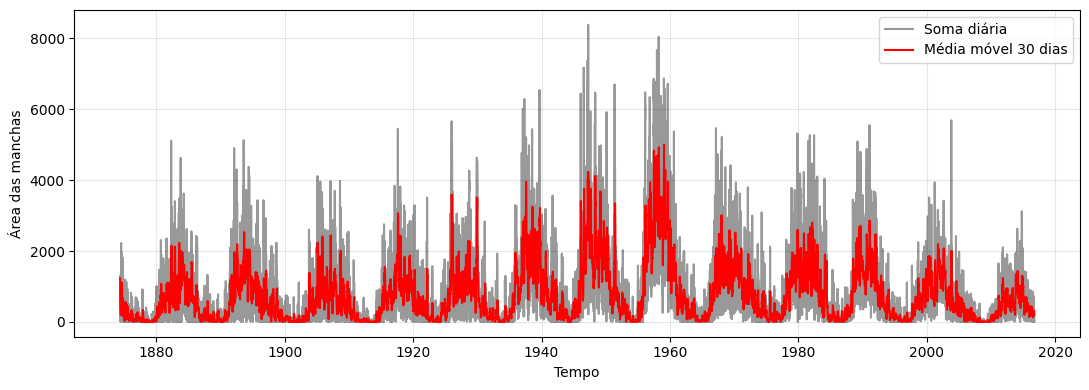

In [49]:
# Vamos recontruir as datas no formato necessário para utilizar o pandas to_datetime, ele facilitará o manuseio de séries temporais

# A partir das colunas separadas de ano, mês e dia, criamos um objeto datetime para cada linha.
ano = df['ano']
mes = df['mes']
dia = df['dia']
datas = pd.to_datetime({'year': ano, 'month': mes, 'day': dia}, errors='coerce')

# Cria uma cópia do DataFrame com a nova coluna 'data', a ideia de criar uma cópia serve como um forma de não alterarmos as informações
# na tabela original.
dfdiario = df.copy()
dfdiario['data'] = datas

# Soma diária da área das manchas

# Agrupa as linhas pelo dia (freq='D') e soma a coluna 'area' de cada dia.
diaria = dfdiario.groupby(pd.Grouper(key='data', freq='D'))['area'].sum().sort_index()

# Vamos calculra a média móvel de 30 dias com a função .rolling do pandas.
# Suavizaremos a série usando janela de 30 dias (min_periods=2 garante cálculo mesmo com poucos dados no início).
ma30 = diaria.rolling(window=30, min_periods=2).mean()

# Plot das duas curvas
plt.figure(figsize=(11,4))
plt.plot(diaria.index, diaria.values, alpha=0.4, label='Soma diária', c='k') # curva preta = valores brutos diários
plt.plot(ma30.index, ma30.values, label='Média móvel 30 dias', c='red') # curva vermelha = suavizada
plt.xlabel('Tempo')
plt.ylabel('Área das manchas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### **Desafio** #2 — Média móvel anual (365)

Refaça o gráfico acima aplicando uma média móvel de 365 dias à série diária e plote.

## 4) Período do Ciclo Solar e Período de Rotação

O **periodograma Lomb–Scargle** é uma técnica usada para encontrar periodicidades em séries temporais que podem não ser uniformemente espaçadas no tempo.

No caso do **ciclo solar**, podemos aplicar o método para os dados das áreas de manchas solares e tentar identificar a periodicidade característica.

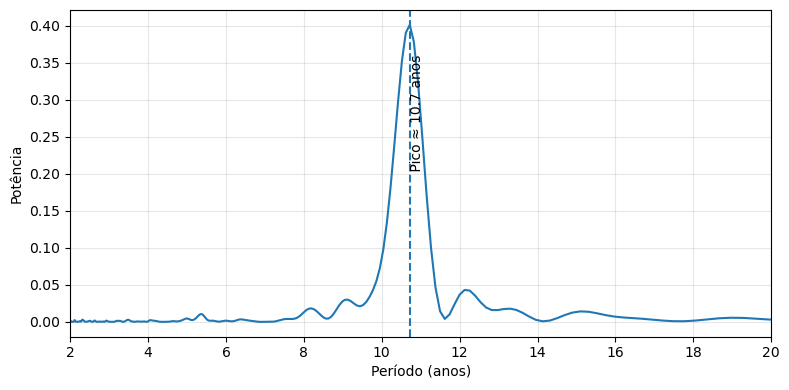

Ciclo solar típico é de ~10.7 anos


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

# Remove valores ausentes da série de média móvel de 30 dias
s = ma30.dropna()

# Converte datas para anos decimais desde o início da série
t_anos = (s.index - s.index[0]).days / 365.25

# Centraliza a série em torno da média (necessário para Lomb–Scargle)
y = s.values.astype(float) - s.values.astype(float).mean()

# Frequências em ciclos por ano para detectar períodos de 2 a 20 anos
f = np.linspace(1/20, 1/2, 500)

# Converte para frequência angular (rad/ano), que o lombscargle exige
w = 2 * np.pi * f

# Calcula o periodograma de Lomb–Scargle
p = lombscargle(t_anos, y, w, normalize=True)

# Converte frequências para períodos (anos)
periodo_anos = 1 / f

# Encontra o índice do pico de potência
pico_id = np.argmax(p)

# Obtém o valor do período correspondente ao pico
pico_periodo = periodo_anos[pico_id]

# Ordena os dados para plotar período crescente
ordem = np.argsort(periodo_anos)

# Cria o gráfico
plt.figure(figsize=(8,4))
plt.plot(periodo_anos[ordem], p[ordem])
plt.xlabel('Período (anos)')
plt.ylabel('Potência')
plt.grid(True, alpha=0.3)
plt.xlim(2, 20)

# Marca no gráfico a posição do pico
plt.axvline(pico_periodo, ls='--')
plt.text(pico_periodo, p.max()*0.9,
         f' Pico ≈ {pico_periodo:.1f} anos',
         rotation=90, va='top')

plt.tight_layout()
plt.show()

# Mostra o valor do pico
print(f'Ciclo solar típico é de ~{pico_periodo.round(1)} anos')

### **Desafio** #3 - Período de Rotação do Sol

Use o periodograma de Lomb-Scargle para encontrar o período de rotação do Sol. Atenção para a amostragem dos dados e a escala de tempo do periodograma. Você é quem escolhe o domínio de frequências com base no período de interesse.

**Entregar:**

a. **Gráfico** — Potência × Período *(dias)*, restringindo a faixa **15–40 d**, com o **pico anotado**.  
b. **Valor do período estimado** — incerteza qualitativa pela largura do pico.  
c. **Comentário** — comente se o valor obtido faz sentido com o período de rotação solar esperado.
